### Урок 3. Связь бизнес-показателей и DS-метрик

#### Домашнее задание
1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

2. При обучении моделей обязательно использовать кроссвалидацию

3. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

4. Сделать выводы о том, какая модель справилась с задачей лучше других

5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки
1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import FeatureUnion

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, log_loss

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

Предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:
 
Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 
Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 
Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 
Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [2]:
df = pd.read_csv('Lection3/train_case2.csv', ';')

/home/w_lander/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns= []
    
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    tick_marks = np.arange(len(classes))
    
    font = {'size' : 10}
    plt.rc('font', **font)
    plt.figure(figsize=(5, 4))
    plt.title(title)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.show()
    return cm

In [6]:
def print_roc_auc(y_test, y_score):
    """Нарисуем roc auc кривую"""
    sns.set(font_scale=1.2)
    sns.set_color_codes("muted")

    plt.figure(figsize=(15, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 12
    plt.plot(fpr, tpr, lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    # plt.savefig("ROC.png")
    plt.show()

def print_roc_auc_many(y_test_y_score:list):
    """Нарисуем roc auc кривую"""
    sns.set(font_scale=1.2)
    sns.set_color_codes("muted") 
    plt.figure(figsize=(5, 4))
    
    for y_test, y_score, label in y_test_y_score:
        fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label=label)
    
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    # plt.savefig("ROC.png")
    plt.show()

In [7]:
# Функция Подсчета FPR, TPR
def calc_TPR_FPR_TNR(cnf_matrix):
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    return TPR, FPR, TNR

In [8]:
sns.set(font_scale=1.4)
sns.set_color_codes("muted")
roc_auc_many = []
attempt_results = []

def attempt(attempt_name, model):
    df = pd.read_csv('Lection3/train_case2.csv', sep=';')
    X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1), 
                                                        df['cardio'],
                                                        random_state=0)

    continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
    cat_cols = ['gender', 'cholesterol']
    base_cols = ['gluc', 'smoke', 'alco', 'active']

    continuos_transformers = []
    cat_transformers = []
    base_transformers = []

    for cont_col in continuos_cols:
        transfomer =  Pipeline([
                    ('selector', NumberSelector(key=cont_col)),
                    ('standard', StandardScaler())
                ])
        continuos_transformers.append((cont_col, transfomer))

    for cat_col in cat_cols:
        cat_transformer = Pipeline([
                    ('selector', ColumnSelector(key=cat_col)),
                    ('ohe', OHEEncoder(key=cat_col))
                ])
        cat_transformers.append((cat_col, cat_transformer))

    for base_col in base_cols:
        base_transformer = Pipeline([
                    ('selector', NumberSelector(key=base_col))
                ])
        base_transformers.append((base_col, base_transformer))


    feats = FeatureUnion(continuos_transformers + cat_transformers + base_transformers)
    feature_processing = Pipeline([('feats', feats)])

    feature_processing.fit_transform(X_train)

    classifier = Pipeline([
        ('features',feats),
        ('classifier', model(random_state = 42)),
    ])

    #запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)

    roc_auc_many.append([y_test, y_score, attempt_name])
    cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
    calc_TPR_FPR_TNR(cnf_matrix)

    return [attempt_name, 
             *calc_TPR_FPR_TNR(cnf_matrix),
             thresholds[ix], 
             fscore[ix], 
             precision[ix], 
             recall[ix], 
             roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]),
             log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1]),
             cv_score,
             cv_score_std]

                      
attempt_results.append(attempt('LogReg', LogisticRegression))
attempt_results.append(attempt('RForest', RandomForestClassifier))
attempt_results.append(attempt('XGB', XGBClassifier))

In [9]:
pd.DataFrame(attempt_results,
            columns=['',
                     'TPR', 
                     'FPR', 
                     'TNR', 
                     'BestThreshold', 
                     'FScore', 
                     'Precision', 
                     'Recall', 
                     'roc auc score', 
                     'log loss score', 
                     'CV score', 
                     'CV score std'])

,,TPR,FPR,TNR,BestThreshold,FScore,Precision,Recall,roc auc score,log loss score,CV score,CV score std
0,LogReg,0.837442,0.448866,0.551134,0.386937,0.730323,0.647431,0.837558,0.784035,0.577960,0.786740,0.008521
1,RForest,0.808410,0.434127,0.565873,0.350000,0.718863,0.642669,0.815553,0.771037,0.599298,0.773450,0.007171
2,XGB,0.828226,0.410204,0.589796,0.347103,0.737890,0.665248,0.828341,0.797228,0.547111,0.797488,0.006448


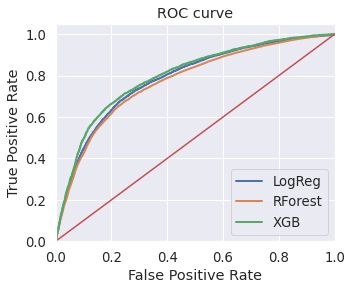

In [10]:
print_roc_auc_many(roc_auc_many)

In [11]:
# При стандартных гиперпараметрах результаты примерно одинаковы